In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import math
import time
from sklearn.gaussian_process.kernels import RBF

In [2]:
def integrate(T, f): 
    tot = 0;
    for i in range(len(T)-1):
        tot = tot + (1/2 * (f[i]+f[i+1]) * (T[1]-T[0]))
    return tot

def get_K0(K,T,T0):
    up_idx = int(np.where(T==T0[-1])[0])
    dw_idx = int(np.where(T==T0[0])[0])
    K_tau_tau = K[dw_idx:up_idx,dw_idx:up_idx]
    K_tau = K[dw_idx:up_idx,:]
    
    return K - np.dot(np.dot(K_tau.T,np.linalg.inv(K_tau_tau)),K_tau)

In [3]:
class data_generator:
    def __init__(self, T, beta, n, covariates_kernel, sigma):
        self.T = T
        self.g = len(self.T)
        self.K = np.fromfunction(np.vectorize(lambda s, t: covariates_kernel(self.T[s], self.T[t])), (g, g), dtype=int)
        self.g = g
        self.n = n
        self.beta = beta
        self.sigma = sigma
    
    def i_o(self):
        x = np.random.multivariate_normal(np.zeros(self.g), self.K, self.n)
        y = np.fromfunction(np.vectorize(lambda i: integrate(self.T,  x[i,:]*beta)+np.random.normal(0,self.sigma,1)), (self.n,), dtype=int)
        return x,y

### UN-OPTIMIZED POSTERIOR:

In [4]:
class posterior:
    def __init__(self, T, T0, x, y, K,sigma):
        self.T = T
        self.x = x
        self.y = y
        self.n = y.shape[0]
        self.g = T.shape[0]
        self.T0 = T0
        self.sigma = sigma
        self.K = K
        self.K0 = get_K0(self.K,self.T,self.T0)
    
    def get_K(self):
        return self.K
    
    def getter(self):
        return self.K0
        
    def Lx0(self,t):   
        L = np.zeros(self.n)    
        for i in np.arange(0,self.n):
            L[i] = integrate(self.T,self.K0[t, :] * self.x[i,:])
        return L
    
    def R0(self,i, j):
        Ri = np.fromfunction(np.vectorize(lambda t: integrate(self.T,self.K0[:,t] * self.x[i,:])), (self.g,), dtype=int)
        Rij = integrate(self.T, Ri * self.x[j,:])
        return  Rij
    
    def M(self):
        return np.fromfunction(np.vectorize(lambda i, j: self.R0(i, j)), (self.n, self.n), dtype=int)+np.identity(self.n)
    
    def posterior_mean_cov(self):
        M_mat = self.M()
        inv = np.linalg.inv(M_mat)
        S11 = np.dot(np.dot(np.transpose(np.ones(M_mat.shape[0])),inv),np.ones(M_mat.shape[0]))
        SY1 = np.dot(np.dot(np.transpose(self.y),inv),np.ones(M_mat.shape[0]))
        
        def m(t):
            mean = np.dot(np.dot(np.transpose(self.Lx0(t)), inv), (self.y - (SY1 / S11) * np.ones(len(self.y))))
            return mean
        def Kstar(s,t):
            cov = (self.sigma**2)*(self.K0[s,t] - np.dot(np.dot(np.transpose(self.Lx0(s)),inv),self.Lx0(t)))
            return cov
        
        m = np.fromfunction(np.vectorize(lambda t: m(t)), (self.g,), dtype=int)
        C = np.fromfunction(np.vectorize(lambda t, s: Kstar(s,t)), (self.g,self.g), dtype=int)
        return m,C
    
    def only_mean(self):
        inv = np.linalg.inv(self.M())
        def m(t):
            mean = np.dot(np.dot(np.transpose(self.Lx0(t)),inv),self.y)
            return mean
        m = np.fromfunction(np.vectorize(lambda t: m(t)), (self.g,), dtype=int)
        return m
    
    def fitted_values(self):
        m = self.only_mean()
        return np.fromfunction(np.vectorize(lambda i: integrate(self.T, self.x[i,:]*m)), (self.n,), dtype=int)


# TEST COMPLEXITY: g = 30, n = 200

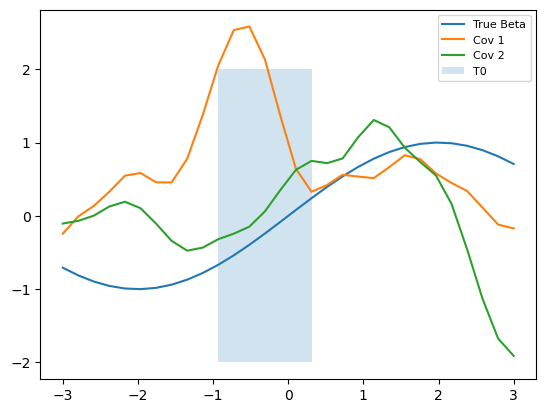

In [66]:
# EXAMPLE
# input
a = -3
b = 3
g = 30
T = np.linspace(a,b,g)
T0 = T[np.where((T<0.5)&(T>-1))]
n = 200
sigma = 1
beta = np.sin(np.linspace(a,b,g)*np.pi/4)
def covariates_kernel(s,t):
    return np.exp(-2*(t-s)**2)
def prior_kernel(s,t):
    return np.exp(-2*((t-s)**2))
#generation
data = data_generator(T,beta,n,covariates_kernel, sigma)
x,y = data.i_o()

plt.plot(T,beta,label='True Beta')
plt.plot(T,x[0,:],label='Cov 1')
plt.plot(T,x[1,:],label='Cov 2')
plt.fill_betweenx(y=[-2, 2], x1 = T0[0], x2 = T0[-1],alpha=0.2,label='T0')
plt.legend(fontsize=8)
K = np.fromfunction(np.vectorize(lambda s, t: prior_kernel(T[s], T[t])), (g, g), dtype=int)

# OPTIMIZING INTEGRATE FUNCTION

### OLD INTEGRATION

In [60]:
def integrate(T, f): 
    tot = 0;
    for i in range(len(T)-1):
        tot = tot + (1/2 * (f[i]+f[i+1]) * (T[1]-T[0]))
    return tot

In [61]:
x_ex = np.linspace(0,np.pi,10000)
f_ex = np.sin(x_ex)

integrate(x_ex,f_ex)

1.999999983547371

### PROPOSED OPTIMIZATIONS

In [62]:
# proposed optimizations
scipy.integrate.trapezoid(f_ex,x_ex), np.trapz(f_ex,x_ex)

(1.999999983547369, 1.999999983547369)

In [63]:
st_old = time.time()
integrate(x_ex,f_ex)
time_old = time.time()-st_old

st_new1 = time.time()
np.trapz(f_ex,x_ex)
time_new1 = time.time()-st_new1

st_new2 = time.time()
scipy.integrate.trapezoid(f_ex,x_ex)
time_new2 = time.time()-st_new2

time_old,time_new1,time_new2

(0.016110658645629883, 0.0010390281677246094, 0.0)

### OPTIMIZED POSTERIOR CLASSES

In [64]:
# optimized posterior
class posterior21: #with numpy
    def __init__(self, T, T0, x, y, K,sigma):
        self.T = T
        self.x = x
        self.y = y
        self.n = y.shape[0]
        self.g = T.shape[0]
        self.T0 = T0
        self.sigma = sigma
        self.K = K
        self.K0 = get_K0(self.K,self.T,self.T0)
    
    def get_K(self):
        return self.K
    
    def getter(self):
        return self.K0
        
    def Lx0(self,t):   
        L = np.zeros(self.n)    
        for i in np.arange(0,self.n):
            L[i] = np.trapz(self.K0[t, :] * self.x[i,:], self.T)
        return L
    
    def R0(self,i, j):
        Ri = np.fromfunction(np.vectorize(lambda t: np.trapz(self.K0[:,t] * self.x[i,:],self.T)), (self.g,), dtype=int)
        Rij = np.trapz(Ri * self.x[j,:], self.T)
        return  Rij
    
    def M(self):
        return np.fromfunction(np.vectorize(lambda i, j: self.R0(i, j)), (self.n, self.n), dtype=int)+np.identity(self.n)
    
    def posterior_mean_cov(self):
        M_mat = self.M()
        inv = np.linalg.inv(M_mat)
        S11 = np.dot(np.dot(np.transpose(np.ones(M_mat.shape[0])),inv),np.ones(M_mat.shape[0]))
        SY1 = np.dot(np.dot(np.transpose(self.y),inv),np.ones(M_mat.shape[0]))
        
        def m(t):
            mean = np.dot(np.dot(np.transpose(self.Lx0(t)), inv), (self.y - (SY1 / S11) * np.ones(len(self.y))))
            return mean
        def Kstar(s,t):
            cov = (self.sigma**2)*(self.K0[s,t] - np.dot(np.dot(np.transpose(self.Lx0(s)),inv),self.Lx0(t)))
            return cov
        
        m = np.fromfunction(np.vectorize(lambda t: m(t)), (self.g,), dtype=int)
        C = np.fromfunction(np.vectorize(lambda t, s: Kstar(s,t)), (self.g,self.g), dtype=int)
        return m,C
    
    def only_mean(self):
        inv = np.linalg.inv(self.M())
        def m(t):
            mean = np.dot(np.dot(np.transpose(self.Lx0(t)),inv),self.y)
            return mean
        m = np.fromfunction(np.vectorize(lambda t: m(t)), (self.g,), dtype=int)
        return m
    
    def fitted_values(self):
        m = self.only_mean()
        return np.fromfunction(np.vectorize(lambda i: np.trapz(self.x[i,:]*m,self.T)), (self.n,), dtype=int)
    
    
    
    
    
    
    
class posterior22: #with scipy
    def __init__(self, T, T0, x, y, K,sigma):
        self.T = T
        self.x = x
        self.y = y
        self.n = y.shape[0]
        self.g = T.shape[0]
        self.T0 = T0
        self.sigma = sigma
        self.K = K
        self.K0 = get_K0(self.K,self.T,self.T0)
    
    def get_K(self):
        return self.K
    
    def getter(self):
        return self.K0
        
    def Lx0(self,t):   
        L = np.zeros(self.n)    
        for i in np.arange(0,self.n):
            L[i] = scipy.integrate.trapezoid(self.K0[t, :] * self.x[i,:], self.T)
        return L
    
    def R0(self,i, j):
        Ri = np.fromfunction(np.vectorize(lambda t: scipy.integrate.trapezoid(self.K0[:,t] * self.x[i,:],self.T)), (self.g,), dtype=int)
        Rij = scipy.integrate.trapezoid(Ri * self.x[j,:], self.T)
        return  Rij
    
    def M(self):
        return np.fromfunction(np.vectorize(lambda i, j: self.R0(i, j)), (self.n, self.n), dtype=int)+np.identity(self.n)
    
    def posterior_mean_cov(self):
        M_mat = self.M()
        inv = np.linalg.inv(M_mat)
        S11 = np.dot(np.dot(np.transpose(np.ones(M_mat.shape[0])),inv),np.ones(M_mat.shape[0]))
        SY1 = np.dot(np.dot(np.transpose(self.y),inv),np.ones(M_mat.shape[0]))
        
        def m(t):
            mean = np.dot(np.dot(np.transpose(self.Lx0(t)), inv), (self.y - (SY1 / S11) * np.ones(len(self.y))))
            return mean
        def Kstar(s,t):
            cov = (self.sigma**2)*(self.K0[s,t] - np.dot(np.dot(np.transpose(self.Lx0(s)),inv),self.Lx0(t)))
            return cov
        
        m = np.fromfunction(np.vectorize(lambda t: m(t)), (self.g,), dtype=int)
        C = np.fromfunction(np.vectorize(lambda t, s: Kstar(s,t)), (self.g,self.g), dtype=int)
        return m,C
    
    def only_mean(self):
        inv = np.linalg.inv(self.M())
        def m(t):
            mean = np.dot(np.dot(np.transpose(self.Lx0(t)),inv),self.y)
            return mean
        m = np.fromfunction(np.vectorize(lambda t: m(t)), (self.g,), dtype=int)
        return m
    
    def fitted_values(self):
        m = self.only_mean()
        return np.fromfunction(np.vectorize(lambda i: scipy.integrate.trapezoid(self.x[i,:]*m,self.T)), (self.n,), dtype=int)

### OPTIMIZING INTEGRATION: PERFORMANCE CHECK

In [67]:
# performance check
p1 = posterior(T,T0,x,y,K,sigma)
p21 = posterior21(T,T0,x,y,K,sigma)
p22 = posterior22(T,T0,x,y,K,sigma)

st_old = time.time()
fitted1 = p1.fitted_values()
time_old = time.time()-st_old

st_new1 = time.time()
fitted21 = p21.fitted_values()
time_new1 = time.time()-st_new1

st_new2 = time.time()
fitted22 = p22.fitted_values()
time_new2 = time.time()-st_new2

time_old,time_new1,time_new2 #np.trapz seems to be more efficent

(24.65673804283142, 15.986731052398682, 16.139418363571167)

### OPTIMIZING INTEGRATION: QUALITY CHECK

In [69]:
# coherency check
m1,cov1 = p1.posterior_mean_cov()
m21,cov21 = p21.posterior_mean_cov()
m22,cov22 = p22.posterior_mean_cov()

The Mean Absolute Deviation in fitted values using np.trapz is 1.7512154920629185e-14
The Mean Absolute Deviation in fitted values using scipy.integrate.trapezoid is 1.7512154920629185e-14


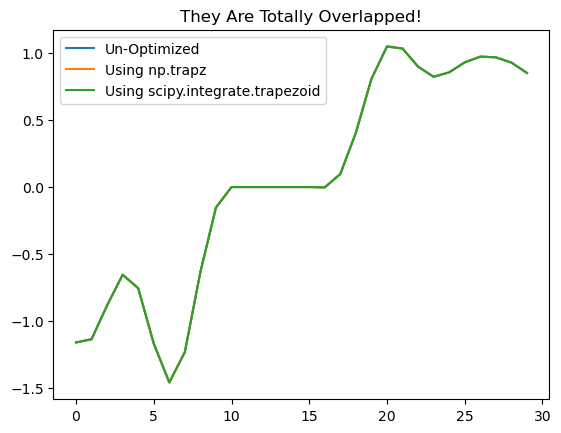

In [70]:
plt.plot(m1, label='Un-Optimized')
plt.plot(m21,label = 'Using np.trapz')
plt.plot(m22,label = 'Using scipy.integrate.trapezoid')
plt.title('They Are Totally Overlapped!')
plt.legend()
print('The Mean Absolute Deviation in fitted values using np.trapz is '+str(np.average(abs(fitted1-fitted21))))
print('The Mean Absolute Deviation in fitted values using scipy.integrate.trapezoid is '+str(np.average(abs(fitted1-fitted22))))

### OPTIMIZING INTEGRATION: CONCLUSIONS

- By using np.trapz the procedure is 1.54 times faster
- By using scipy.integrate.trapezoid the procedure is 1.52 times faster
- The quality check shows equivalence between np.trapz and scipy.integrate.trapezoid
- Since the fitted values with the two proposed integration methods are exactly equal, we can conclude that with those optimizations we are improving numerical quality of our calculations :)
- ...
- We choose np.trapz

# OPTIMIZING COVARIANCE CALCULATION

### OLD CALCULATION

In [75]:
def R0(i, j):
    Ri = np.fromfunction(np.vectorize(lambda t: integrate(T,K[:,t] * x[i,:])), (g,), dtype=int)
    Rij = integrate(T, Ri * x[j,:])
    return  Rij

def M():
    return np.fromfunction(np.vectorize(lambda i, j: R0(i, j)), (n, n), dtype=int)

### PROPOSED OPTIMIZATIONS

In [76]:
# be aware: we are using K instead of K0. This is just for computational purposes
def R02(i, j):
    Ri = np.trapz(K[:, :] * x[i,:], T, axis=1)
    Rij = np.trapz(Ri * x[j, :],T)
    return Rij

def M2():
    return np.array([[R02(i, j) for j in range(n)] for i in range(n)])

In [78]:
# performance check
st_old = time.time()
mat1 = M()
time_old = time.time()-st_old

st_new = time.time()
mat2 = M2()
time_new = time.time()-st_new

time_old,time_new

(25.10802149772644, 1.322692632675171)

In [79]:
# coherency check
mat1-mat2

array([[-3.55271368e-15, -4.44089210e-16,  8.88178420e-16, ...,
         2.22044605e-16,  1.77635684e-15, -6.66133815e-16],
       [-4.44089210e-16, -1.33226763e-15, -1.11022302e-15, ...,
        -8.88178420e-16,  4.44089210e-16,  2.22044605e-16],
       [ 0.00000000e+00, -6.66133815e-16,  4.44089210e-16, ...,
        -2.22044605e-16,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 4.44089210e-16, -8.88178420e-16,  0.00000000e+00, ...,
        -8.88178420e-16,  1.77635684e-15,  0.00000000e+00],
       [ 0.00000000e+00,  6.66133815e-16, -2.22044605e-16, ...,
         8.88178420e-16, -1.77635684e-15,  0.00000000e+00],
       [-2.22044605e-16,  2.22044605e-16, -2.22044605e-16, ...,
         8.88178420e-16,  0.00000000e+00,  0.00000000e+00]])

### OPTIMIZED POSTERIOR CLASS

In [80]:
# optimized posterior
class posterior3:
    def __init__(self, T, T0, x, y, K,sigma):
        self.T = T
        self.x = x
        self.y = y
        self.n = y.shape[0]
        self.g = T.shape[0]
        self.T0 = T0
        self.sigma = sigma
        self.K = K
        self.K0 = get_K0(self.K,self.T,self.T0)
    
    def get_K(self):
        return self.K
    
    def getter(self):
        return self.K0
        
    def Lx0(self,t):   
        L = np.zeros(self.n)    
        for i in np.arange(0,self.n):
            L[i] = np.trapz(self.K0[t, :] * self.x[i,:], self.T)
        return L
    
    def R0(self,i, j):
        Ri = np.trapz(self.K0[:, :] * self.x[i, :], self.T, axis=1)
        Rij = np.trapz(Ri * self.x[j, :],self.T)
        return Rij

    def M(self):
        return np.array([[self.R0(i, j) for j in range(self.n)] for i in range(self.n)])+np.identity(self.n)

    def posterior_mean_cov(self):
        M_mat = self.M()
        inv = np.linalg.inv(M_mat)
        S11 = np.dot(np.dot(np.transpose(np.ones(M_mat.shape[0])),inv),np.ones(M_mat.shape[0]))
        SY1 = np.dot(np.dot(np.transpose(self.y),inv),np.ones(M_mat.shape[0]))
        
        def m(t):
            mean = np.dot(np.dot(np.transpose(self.Lx0(t)), inv), (self.y - (SY1 / S11) * np.ones(len(self.y))))
            return mean
        def Kstar(s,t):
            cov = (self.sigma**2)*(self.K0[s,t] - np.dot(np.dot(np.transpose(self.Lx0(s)),inv),self.Lx0(t)))
            return cov
        
        m = np.fromfunction(np.vectorize(lambda t: m(t)), (self.g,), dtype=int)
        C = np.fromfunction(np.vectorize(lambda t, s: Kstar(s,t)), (self.g,self.g), dtype=int)
        return m,C
    
    def only_mean(self):
        inv = np.linalg.inv(self.M())
        def m(t):
            mean = np.dot(np.dot(np.transpose(self.Lx0(t)),inv),self.y)
            return mean
        m = np.fromfunction(np.vectorize(lambda t: m(t)), (self.g,), dtype=int)
        return m
    
    def fitted_values(self):
        m = self.only_mean()
        return np.fromfunction(np.vectorize(lambda i: np.trapz(self.x[i,:]*m,self.T)), (self.n,), dtype=int)

### PERFORMANCE CHECK

In [81]:
# performance check
p1 = posterior(T,T0,x,y,K,sigma)
p3 = posterior3(T,T0,x,y,K,sigma)

st_old = time.time()
fitted1 = p1.fitted_values()
time_old = time.time()-st_old

st_new = time.time()
fitted3 = p3.fitted_values()
time_new = time.time()-st_new

time_old,time_new

(24.99275803565979, 1.4676508903503418)

### QUALITY CHECK

In [82]:
# coherency check
m1,cov1 = p1.posterior_mean_cov()
m3,cov3 = p3.posterior_mean_cov()

The Mean Absolute Deviation in fitted values obtained by using optimized version is 4.52454535643243e-12


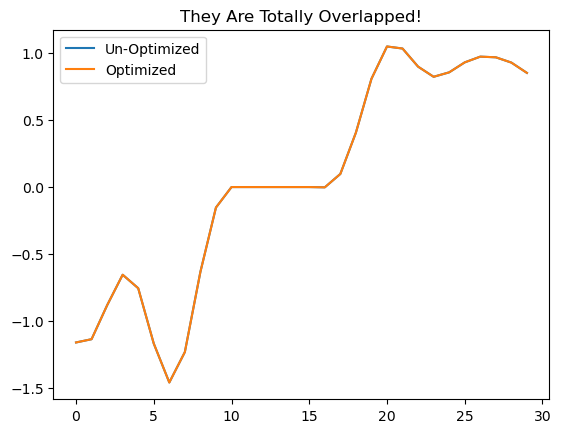

In [83]:
plt.plot(m1,label='Un-Optimized')
plt.plot(m3,label='Optimized')
plt.title('They Are Totally Overlapped!')
plt.legend()
print('The Mean Absolute Deviation in fitted values obtained by using optimized version is '+str(np.average(abs(fitted1-fitted3))))

- By using np.trapz the procedure is 17 times faster
- The quality check shows equivalence between un-optimized and optimized version